In [3]:
import mysql.connector
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns

from pylab import rcParams
rcParams['figure.figsize'] = 15,10

import datetime

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# matplot 한글 설정
import platform
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

if platform.system() == "Darwin":
    print("Hangul Setting OK for Mac")
    rc("font", family = "Arial Unicode MS")
elif platform.system() == "Windows":
    print("This py not setting for Window sry")
else:
    print("We don't know System")
    
plt.rcParams["axes.unicode_minus"] = False

## DB에서 데이터 가져오기 부분 생략

In [ ]:
import re
def date_hour(timstamp):
    return re.sub('(?<=[0-9]:)([0-9]*.)', '00:', str(timstamp))[:-1]


def makeTimeList(d_min, d_max):
    date_max = (pd.to_datetime(date_hour(d_max), format='%Y-%m-%d %H:%M:%S'))
    date_min = (pd.to_datetime(date_hour(d_min), format='%Y-%m-%d %H:%M:%S'))
    result = []
    cnt_hour = 0
    while  date_max != date_min + datetime.timedelta(hours=cnt_hour):
        result.append(np.datetime64(date_min + datetime.timedelta(hours=cnt_hour)))
        cnt_hour+=1

    return result

def get_add_blank_time_df(df, detect_range):
    result = pd.DataFrame()
    for dh in detect_range:
        if dh in df['date_hour'].values:
            result = pd.concat([result, df[df['date_hour'].isin([dh])]])
        else:
            pass
            tmp = pd.DataFrame({
                'date_hour' : dh,
                'itemName' : df['itemName'].unique(),
                'size' : 0,
                'mean' : 0
            })
            result = pd.concat([result, tmp])

    return result.reset_index(drop=True)

In [ ]:
weekdays_kor = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

def getWeekdaysNum(value):
    return value.weekday()

def getDateHour(value):
    return value.hour


In [ ]:

prices = sold_histoy.drop('itemId', axis=1)

In [ ]:
prices = prices.drop_duplicates()

In [ ]:
prices['sold_Date']  = pd.to_datetime(prices['sold_Date'] , format='%Y-%m-%d %H:%M:%S', errors='raise')
prices['unitPrice'] = prices['unitPrice'].astype('float')
prices['quantity'] = prices['quantity'].astype('int')
prices['weekdays'] = prices['sold_Date'].apply(getWeekdaysNum)
prices['hour'] = prices['sold_Date'].apply(getDateHour)

itemName_dict = {value : idx for idx, value in enumerate(prices['itemName'].unique())}

def NameToCode(value):
    return itemName_dict[value]

prices['itemName'] = prices['itemName'].apply(NameToCode)

In [ ]:
item_1 = prices[prices['itemName'] == 1]

In [ ]:
item_1 = item_1.sort_values('sold_Date')

In [ ]:
item_1.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 193 to 17592
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   sold_Date   622 non-null    datetime64[ns]
 1   itemName    622 non-null    int64         
 2   quantity    622 non-null    int64         
 3   unitPrice   622 non-null    float64       
 4   sold_Date2  622 non-null    datetime64[ns]
 5   weekdays    622 non-null    int64         
 6   hour        622 non-null    int64         
dtypes: datetime64[ns](2), float64(1), int64(4)
memory usage: 38.9 KB


In [ ]:
pivot_item_1 = item_1.pivot_table(index='sold_Date', values='unitPrice', aggfunc='sum')

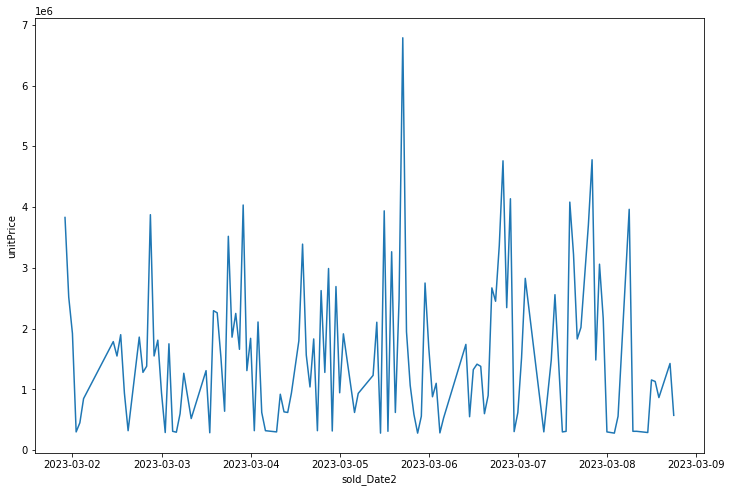

In [ ]:
plt.figure(figsize=(12,8))
sns.lineplot(pivot_item_1.index, pivot_item_1['unitPrice'])
plt.show()

# ARIMA

* AR (Auto Regressive Model)
  - p : 시점 전의 자료가 현재 시점의 데이터에 영향을 주는 자기회귀모델
  - ACF : 자기상관함수 / 특정 구간내 데이터간 상관관계
  - PACF : 부분자기상관함수

In [ ]:
import statsmodels.tsa.api as tsa

y = pivot_item_1['unitPrice'].resample('1H').mean()

In [ ]:
y.isna().sum()

40

In [ ]:
y1 = y.fillna(method='ffill')

# 시계열 분해
- Trend(추세 요인)
- Seasonality(계절요인)
- Resdiual(불규칙 또는 순환 요인)

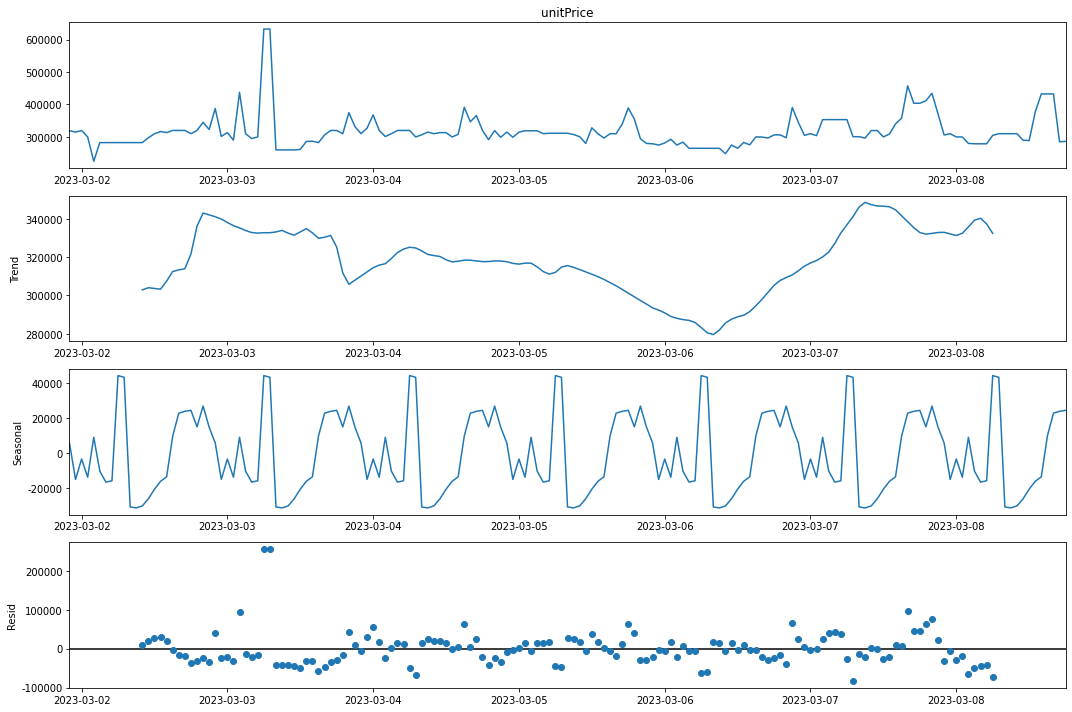

In [ ]:
model = tsa.seasonal_decompose(y1, model='additive')
fig = model.plot()
plt.show()

In [ ]:
import itertools

In [ ]:
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p,d,q))]

In [ ]:
param_list = []
param_seasonal_list = []
result_AIC_list = []

In [ ]:
for param in pdq:
  for param_seasonal in seasonal_pdq:
    try:
      mod = tsa.statespace.SARIMAX(y1, order = param,
                                   seasonal_order = param_seasonal,
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
      results = mod.fit()
      param_list.append(param)
      param_seasonal_list.append(param_seasonal)
      result_AIC_list.append(results.aic)
    except:
      continue

In [ ]:
ARIMA_list = pd.DataFrame({'Parameter' : param_list,
                           'Seasonal' : param_seasonal_list,
                           'AIC' : result_AIC_list})
ARIMA_list.to_excel('arima_model_list.xlsx')

- **Likelihood(최대우도) : 특정 데이터 모수로부터 추출되었을 가능도**
  - 특정 값에 대한 분포의 확률 추정(연속 확률 밀도 함수 pdq의 y값)
  
- **AIC (Akaike Information Criterion) : 데이터에 대한 모델의 상대적 품질**
  - AIC = -2 ln(L) + 2k
  - 값이 낮을수록 모형 적합도가 높은 것을 의미
  
- **BIC(Bayes Information Criterion)**
  - BIC = -2 lm(L) + log(n)p
  - 설명변수가 많을때 AIC에 더 많은 패널티를 부여해 모델을 평가
  
- **HQIC(Hanan Quinn Information Critierion)**
  - HQIC = -2 ln(L) + 2k ln(ln(n))
  - 최대우도 미세조정 함수


In [ ]:
# AIC가 낮을수록 좋은 모델 
ARIMA_list.sort_values('AIC')

,Parameter,Seasonal,AIC
19,"(0, 1, 0)","(0, 1, 1, 24)",2775.524314
23,"(0, 1, 0)","(1, 1, 1, 24)",2777.085688
63,"(1, 1, 1)","(1, 1, 1, 24)",2802.349863
27,"(0, 1, 1)","(0, 1, 1, 24)",2807.483391
31,"(0, 1, 1)","(1, 1, 1, 24)",2808.770115
...,...,...,...
16,"(0, 1, 0)","(0, 0, 0, 24)",4000.489549
48,"(1, 1, 0)","(0, 0, 0, 24)",4001.115943
32,"(1, 0, 0)","(0, 0, 0, 24)",4024.873104
8,"(0, 0, 1)","(0, 0, 0, 24)",4486.425446


In [ ]:
mod = tsa.statespace.SARIMAX(y1, order=(0,1,0), seasonal_order=(0,1,1,24),
                             enforce_stationarity=False,
                             enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            unitPrice   No. Observations:                  165
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 24)   Log Likelihood               -1385.762
Date:                              Wed, 08 Mar 2023   AIC                           2775.524
Time:                                      10:50:15   BIC                           2781.014
Sample:                                  03-01-2023   HQIC                          2777.753
                                       - 03-08-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L24      -0.7228      0.019    -37.244      0.000      -0.761      -0.685
sigma2      1.651e+

- Order (p, d, q), Seasonal Order (P,D,Q,M)

  - p : AR에서의 p값 (p 구간 내 데이터 사이의 상관관계)
  - d : 차분
  - q : MA PACF 편상관계수 q 값
  - P : 계절성 주기에서의 p값
  - D : 계절성 여부 (0 or 1)
  - Q : ACF 기준으로 반복 횟수
  - M : 계절성 주기가 어느정도 있는지

  
- Ljung - Box Test : 일정 기간동안 관측치가 랜덤이고 독립적인지 여부를 테스트 
  - 귀무 : 데이터가 상관을 나타내지 않는다.
  - 대립 : 데이터가 상관을 나타낸다.
-> 현재 결과는 관측치와 오차가 독립
  
- Jarque-Bera Test : 왜도와 첨도가 정규분포와 일치하는지 가설검정
  - SARIMAX : 잔차의 분포가 정규분포인가?
  - 귀무 : 잔차가 정규분포와 일치한다.
  - 대립 : 잔차가 정규분포와 일치하지 않는다.
-> 현재 결과는 정규분포와 일치하지 않는다. 트랜드가 숨겨져있다. 새로운값을 예측할때 영향을 줄 수 있다.

  

    
    